In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Importing the Quarterly data from OECD on Danish GDP 1990-2023
gdp = pd.read_csv(".//QGDP.csv", sep=';', header=None)
cons = pd.read_csv(".//Consumer.csv", sep=';')
indu = pd.read_csv(".//Industry.csv", sep=';')

In [58]:
#Selecting the relevant columns
gdp = gdp[[2, 3]]

## There is 13 questions the consumers have answered in the survey:
## - COF	Confidence Indicator (Q1 + Q2 + Q4 + Q9) / 4 (CONS.DK.TOT.COF.B.M)
## - 1	Financial situation over last 12 months (CONS.DK.TOT.1.B.M)
## - 2	Financial situation over next 12 months (CONS.DK.TOT.2.B.M)
## - 3	General economic situation over last 12 months (CONS.DK.TOT.3.B.M)
## - 4	General economic situation over next 12 months (CONS.DK.TOT.4.B.M)
## - 5	Price trends over last 12 months (CONS.DK.TOT.5.B.M)
## - 6	Price trends over next 12 months (CONS.DK.TOT.6.B.M)
## - 7	Unemployment expectations over next 12 months (CONS.DK.TOT.7.B.M)
## - 8	Major purchases at present (CONS.DK.TOT.8.B.M)
## - 9	Major purchases over next 12 months (CONS.DK.TOT.9.B.M)
## - 10	Savings at present (CONS.DK.TOT.10.B.M)
## - 11	Savings over next 12 months (CONS.DK.TOT.11.B.M)
## - 12	Statement on financial situation of household (CONS.DK.TOT.12.B.M)

##Selecting COF
cons = cons[['Time', 'CONS.DK.TOT.COF.B.M']]

##There is 8 relevant questions in the industry survey:
## - COF	Confidence Indicator (Q2 - Q4 + Q5) / 3 (INDU.DK.TOT.COF.B.M)
## - 1	Production trend observed in recent months (INDU.DK.TOT.1.B.M)
## - 2	Assessment of order-book levels (INDU.DK.TOT.2.B.M)
## - 3	Assessment of export order-book levels (INDU.DK.TOT.3.B.M)
## - 4	Assessment of stocks of finished products (INDU.DK.TOT.4.B.M)
## - 5	Production expectations for the months ahead (INDU.DK.TOT.5.B.M)
## - 6	Selling price expectations for the months ahead (INDU.DK.TOT.6.B.M)
## - 7	Employment expectations for the months ahead (INDU.DK.TOT.7.B.M)

## Selecting COF
indu = indu[['Time', 'INDU.DK.TOT.COF.B.M']]

In [59]:
#Renaming the columns
gdp = gdp.rename(columns={2: 'Time', 3: 'Value'})
cons = cons.rename(columns={'CONS.DK.TOT.COF.B.M': 'Value'})
indu = indu.rename(columns={'INDU.DK.TOT.COF.B.M': 'Value'})

#Converting the Time column to datetime
cons['Time'] = pd.to_datetime(cons['Time'], format='%d-%m-%Y')
indu['Time'] = pd.to_datetime(indu['Time'], format='%d-%m-%Y')
gdp['Time'] = pd.to_datetime(gdp['Time'])

# Converting the Value column to float64 in indu and cons
indu['Value'] = pd.to_numeric(indu['Value'], errors='coerce').astype('float64')

cons['Value'] = pd.to_numeric(cons['Value'], errors='coerce').astype('float64')


#Checking the data types
print("Data types in 'indu' dataframe:")
print(indu.dtypes)

print("\nData types in 'cons' dataframe:")
print(cons.dtypes)

print("\nData types in 'gdp' dataframe:")
print(gdp.dtypes)

Data types in 'indu' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'cons' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object

Data types in 'gdp' dataframe:
Time     datetime64[ns]
Value           float64
dtype: object


In [60]:
# Resample indu and cons to quarterly frequency, using the mean value per quarter
indu_quarterly = indu.resample('Q', on='Time').mean()
cons_quarterly = cons.resample('Q', on='Time').mean()

# Adjust the datetime to the first day of the quarter
indu_quarterly['Time'] = indu_quarterly.index.to_period('Q').asfreq('Q-DEC', 'start').to_timestamp()
cons_quarterly['Time'] = cons_quarterly.index.to_period('Q').asfreq('Q-DEC', 'start').to_timestamp()

#Resetting the index of the new dataframes
indu_quarterly.reset_index(drop=True, inplace=True)
cons_quarterly.reset_index(drop=True, inplace=True)

#Checking the data types
print(indu_quarterly.dtypes)
print(cons_quarterly.dtypes)

Value           float64
Time     datetime64[ns]
dtype: object
Value           float64
Time     datetime64[ns]
dtype: object


In [61]:
#Filtering the data to only include the years 1990-2023, as this is the limitation in gdp dataset
indu_quarterly = indu_quarterly[(indu_quarterly['Time'] >= '1990-01-01') & (indu_quarterly['Time'] < '2024-01-01')]
cons_quarterly = cons_quarterly[(cons_quarterly['Time'] >= '1990-01-01') & (cons_quarterly['Time'] < '2024-01-01')]

In [62]:
#Cleanup
cons = cons_quarterly
indu = indu_quarterly

cons.reset_index(drop=True, inplace=True)
indu.reset_index(drop=True, inplace=True)

del cons_quarterly, indu_quarterly

In [63]:
#Using the period 2016-2020 for training and 2020-2023 for testing
indu_train = indu[(indu['Time'] >= '2016-01-01') & (indu['Time'] < '2020-01-01')]
cons_train = cons[(cons['Time'] >= '2016-01-01') & (cons['Time'] < '2020-01-01')]
gdp_train = gdp[(gdp['Time'] >= '2016-01-01') & (gdp['Time'] < '2020-01-01')]

indu_test = indu[(indu['Time'] >= '2020-01-01') & (indu['Time'] < '2024-01-01')]
cons_test = cons[(cons['Time'] >= '2020-01-01') & (cons['Time'] < '2024-01-01')]
gdp_test = gdp[(gdp['Time'] >= '2020-01-01') & (gdp['Time'] < '2024-01-01')]

In [64]:
#Combine the training data by matching the time
train = pd.merge(indu_train, cons_train, on='Time', how='inner')
train = pd.merge(train, gdp_train, on='Time', how='inner')


#Combine the testing data by matching the time
test = pd.merge(indu_test, cons_test, on='Time', how='inner')
test = pd.merge(test, gdp_test, on='Time', how='inner')

#Renaming the columns
train.columns = ['indu','Time', 'cons', 'gdp']
test.columns = ['indu','Time', 'cons', 'gdp']


In [65]:
# Installing Python 3.10.12
%pip install python==3.10.12

# Installing accelerate package for faster computation
%pip install accelerate

# Installing keras package for deep learning
%pip install keras

# Installing tensorflow package for deep learning
%pip install tensorflow

# Installing torch package for deep learning
%pip install torch

# Installing transformers package for deep learning
%pip install transformers

# Installing xgboost package for gradient boosting
%pip install xgboost

# Installing langchain package for natural language processing
%pip install langchain

# Installing pmdarima package for time series analysis
%pip install pmdarima

# Installing statsmodels package for time series analysis
%pip install statsmodels

# Installing pandas package for data manipulation
%pip install pandas

# Installing numpy package for numerical computation
%pip install numpy

# Installing matplotlib package for data visualization
%pip install matplotlib

# Installing scikit-learn package for machine learning
%pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement python==3.10.12 (from versions: none)
ERROR: No matching distribution found for python==3.10.12


In [66]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.summarize import load_summarize_chain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chains.summarize import load_summarize_chain

In [67]:
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline
import os
from google.colab import userdata

# Set the Hugging Face API token as an environment variable
os.environ["HF_TOKEN"] = userdata.get("huggingface_key")

#Set the device to use
device = torch.device("cuda")


MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torchscript=True, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto"
)

# Create a configuration for text generation based on the specified model name
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)

# Set the maximum number of new tokens in the generated text to 1024.
# This limits the length of the generated output to 1024 tokens.
generation_config.max_new_tokens = 1024

# Set the temperature for text generation. Lower values (e.g., 0.0001) make output more deterministic, following likely predictions.
# Higher values make the output more random.
generation_config.temperature = 0.01

# Set the top-p sampling value. A value of 0.95 means focusing on the most likely words that make up 95% of the probability distribution.
generation_config.top_p = 0.95

# Enable text sampling. When set to True, the model randomly selects words based on their probabilities, introducing randomness.
generation_config.do_sample = True

# Set the repetition penalty. A value of 1.15 discourages the model from repeating the same words or phrases too frequently in the output.
generation_config.repetition_penalty = 1.15


# Create a text generation pipeline using the initialized model, tokenizer, and generation configuration
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    generation_config=generation_config
)


tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [68]:
# To make the model one-step ahead, a pre-prompt is not used
pre_prompt = ("")

# Create a list of prompts for all instances in the test set
all_prompts = []

def get_quarter(date):
    return pd.Timestamp(date).to_period('Q')

for i, row in test.iterrows():
    prompt = ("Your task is to provide a GDP forecast for Denmark in the quarter " + str(get_quarter(row['Time'])) + " based solely on the following historical data from previous quarters:")

    # Get the required historical data from the training set in reverse order
    train_indices = [train.index[-1 - j] for j in range(4)][::-1]
    train_data = [str(train.loc[idx, 'Time'].date()) + ": GDP; " + str(train.loc[idx, 'gdp']) + ", Consumer; " + str(train.loc[idx, 'cons']) + ", Industry; " + str(train.loc[idx, 'indu']) for idx in train_indices]
    prompt += ", ".join(train_data) + "."

    if i < 4:
        prompt += "Please provide your forecast in the following format:\n"
        prompt += "In Quarter " + str(get_quarter(row['Time'])) + ", the consumer sentiment is " + str(row['cons']) + ", the industrial sentiment is " + str(row['indu']) + ". GDP is therefore forecasted to be [Prediction] billion DKK."
        prompt += "\n\nNote: Your prediction should be based solely on the provided historical data and should not make any references to future events or circumstances beyond the timeframe covered by the data. Do not explain the process, only return the completed template."
    else:
        prompt += ("Your task is to provide a GDP forecast for Denmark in the quarter " + str(get_quarter(row['Time'])) + " based on the following historical data:"
                   + str(test.iloc[i-1]['Time'].date()) + ": GDP; " + str(test.iloc[i-1]['gdp']) + ", Consumer; " + str(test.iloc[i-1]['cons']) + ", Industry; " + str(test.iloc[i-1]['indu']) + ", "
                   + str(test.iloc[i-2]['Time'].date()) + ": GDP; " + str(test.iloc[i-2]['gdp']) + ", Consumer; " + str(test.iloc[i-2]['cons']) + ", Industry; " + str(test.iloc[i-2]['indu']) + ", "
                   + str(test.iloc[i-3]['Time'].date()) + ": GDP; " + str(test.iloc[i-3]['gdp']) + ", Consumer; " + str(test.iloc[i-3]['cons']) + ", Industry; " + str(test.iloc[i-3]['indu']) + ", "
                   + str(test.iloc[i-4]['Time'].date()) + ": GDP; " + str(test.iloc[i-4]['gdp']) + ", Consumer; " + str(test.iloc[i-4]['cons']) + ", Industry; " + str(test.iloc[i-4]['indu']) + ".")
        prompt += "Please provide your forecast in the following format:\n"
        prompt += "In Quarter " + str(get_quarter(row['Time'])) + ", the consumer sentiment is " + str(row['cons']) + ", the industrial sentiment is " + str(row['indu']) + ". GDP is therefore forecasted to be [Prediction] billion DKK."
        prompt += "\n\nNote: Your prediction should be based solely on the provided historical data and should not make any references to future events or circumstances beyond the timeframe covered by the data. Do not explain the process, only return the completed template."

    all_prompts.append(prompt)

In [69]:
print(all_prompts)

['Your task is to provide a GDP forecast for Denmark in the quarter 2020Q1 based solely on the following historical data from previous quarters:2019-01-01: GDP; 555.8, Consumer; 3.4666666666666663, Industry; -4.666666666666667, 2019-04-01: GDP; 583.2, Consumer; 5.866666666666667, Industry; -3.3333333333333335, 2019-07-01: GDP; 574.4, Consumer; 3.8666666666666667, Industry; -7.0, 2019-10-01: GDP; 597.6, Consumer; 2.8000000000000003, Industry; -10.0.Please provide your forecast in the following format:\nIn Quarter 2020Q1, the consumer sentiment is 2.8333333333333335, the industrial sentiment is -6.333333333333333. GDP is therefore forecasted to be [Prediction] billion DKK.\n\nNote: Your prediction should be based solely on the provided historical data and should not make any references to future events or circumstances beyond the timeframe covered by the data. Do not explain the process, only return the completed template.', 'Your task is to provide a GDP forecast for Denmark in the quar

In [70]:
#Returning a response from the model for each prompt in all_prompts

responses = text_pipeline(all_prompts)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [71]:
#Isolating the predictions from the responses
predictions = [response[0]['generated_text'].split('\n')[0] for response in responses]

In [72]:
#Isolating the generated text from the responses by replacing the prompt with an empty string
generated_text = [response[0]['generated_text'].replace(prompt, '') for response, prompt in zip(responses, all_prompts)]

print(generated_text)

["\n\nBased on the given historical data, the forecast for Denmark's GDP in Q2020Q1 would be:\nIn Quarter 2020Q1, the consumer sentiment is 2.8, the industrial sentiment is -6.333333333333333. GDP is therefore forecasted to be 568.4 billion DKK.", "\n\nBased on the given historical data, the forecast for Denmark's GDP in Q2 2020 would be:\n\nIn Quarter 2020Q2, the consumer sentiment is N/A, the industrial sentiment is -24.666666666666668. GDP is therefore forecasted to be 533.5 billion DKK.", '\n\nBased on the given historical data, the trend for consumer sentiment seems to be increasing while industry sentiment has been fluctuating between negative and positive values. Using this information, we can estimate the Q3 2020 GDP as follows:\n\nIn Quarter 2020Q3, the consumer sentiment is 1.5, the industrial sentiment is -10.0. GDP is therefore forecasted to be 588.1 billion DKK.', "\n\nBased on the given historical data, the average growth rate of the Danish economy over the past four quar

In [83]:
#Extracting the list of prediction values manually

predictions = [
    568.4,   # 2020Q1
    533.5,   # 2020Q2
    588.1,   # 2020Q3
    543.1,   # 2020Q4
    550,    # 2021Q1
    568.5,   # 2021Q2
    652.3333333333333,  # 2021Q3
    652.5,   # 2021Q4
    568.3333333333333,  # 2022Q1
    632.2,   # 2022Q2
    582.3333333333333,  # 2022Q3
    632.1666666666667,  # 2022Q4
    568.3,   # 2023Q1
    552.3,   # 2023Q2
    613.2,   # 2023Q3
    617.5333333333333   # 2023Q4
]


In [85]:
#Adding the predictions to the test dataframe
test['gdp_pred'] = predictions

In [86]:
print(test)

         indu       Time       cons    gdp    gdp_pred
0   -6.333333 2020-01-01   2.833333  570.4  568.400000
1  -21.000000 2020-04-01  -1.333333  555.6  533.500000
2  -10.000000 2020-07-01   1.500000  581.2  588.100000
3   -7.333333 2020-10-01   0.666667  613.8  543.100000
4   -0.666667 2021-01-01   3.566667  588.2  550.000000
5    4.333333 2021-04-01   7.766667  634.5  568.500000
6    4.666667 2021-07-01   8.200000  637.0  652.333333
7    5.666667 2021-10-01   1.933333  691.0  652.500000
8   -1.000000 2022-01-01  -3.366667  659.5  568.333333
9   -2.333333 2022-04-01 -15.100000  714.7  632.200000
10  -7.333333 2022-07-01 -17.266667  719.6  582.333333
11 -17.333333 2022-10-01 -20.166667  737.9  632.166667
12 -14.000000 2023-01-01 -12.566667  691.0  568.300000
13  -6.666667 2023-04-01  -5.866667  698.9  552.300000
14  -7.333333 2023-07-01  -5.600000  669.3  613.200000
15 -12.333333 2023-10-01  -7.300000  732.4  617.533333


In [87]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_percentage_error

#Comparing the forecasted values with the actual values trough RMSE and MAPE
# Calculate the RMSE
rmse_value = rmse(test['gdp'], test['gdp_pred'])
# Calculate the MAPE
mape_value = mean_absolute_percentage_error(test['gdp'], test['gdp_pred'])*100 #Multiplying by 100 to get the percentage

# Print the RMSE
print("The RMSE is", rmse_value)
# Print the MAPE
print("The MAPE is", mape_value)

The RMSE is 83.32871987229586
The MAPE is 10.21740057116991


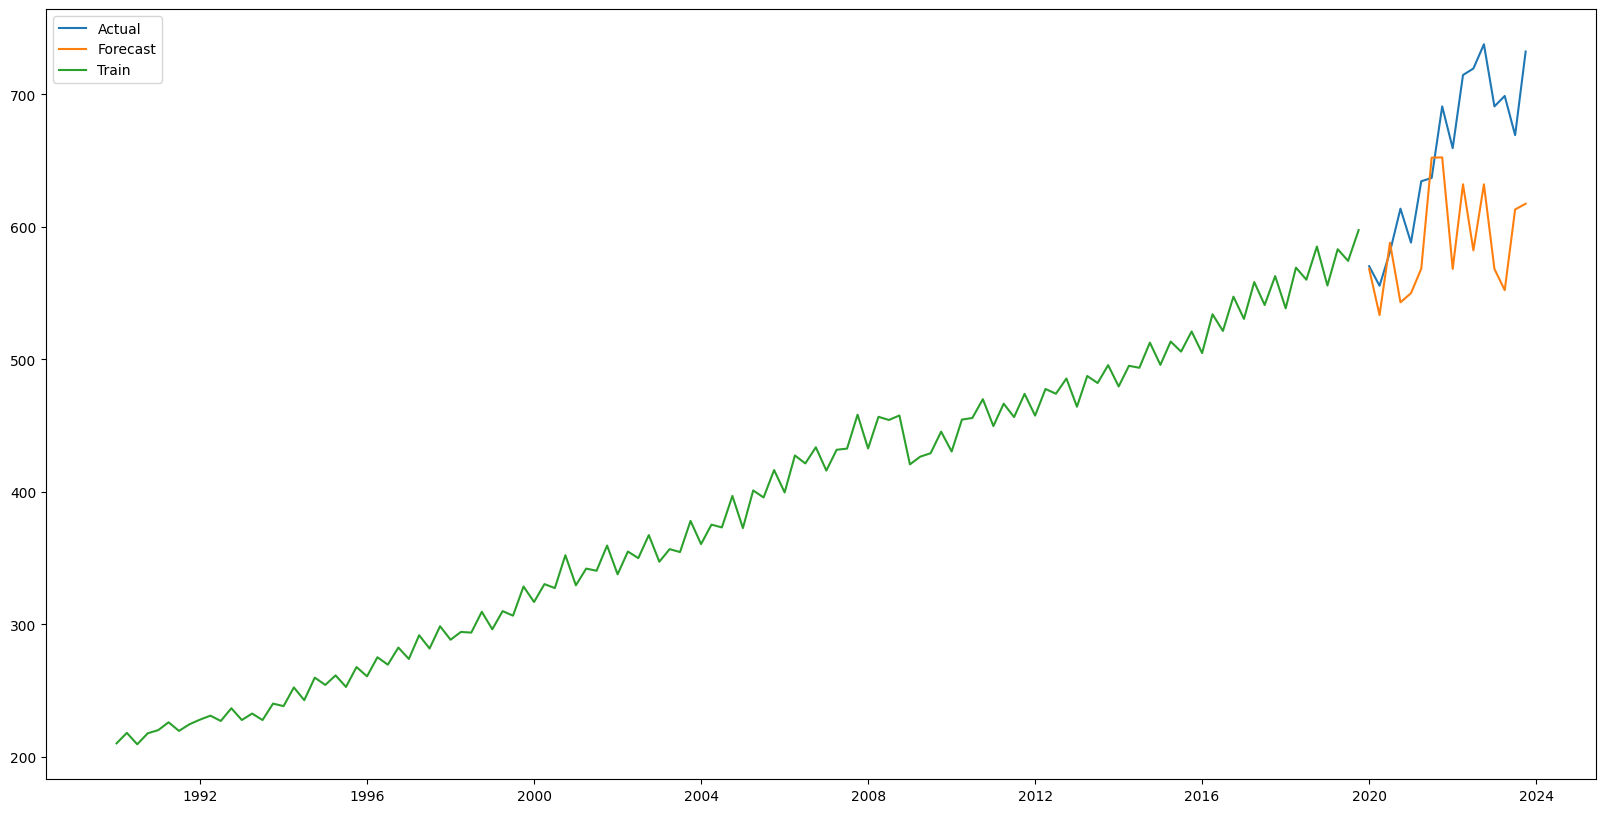

In [88]:
#Converting all relevant columns to numpy arrays
actual = test['gdp'].to_numpy()
forecast = test['gdp_pred'].to_numpy()
test_time = test['Time'].to_numpy()

gdp_train1 = gdp[(gdp['Time'] >= '1990-01-01') & (gdp['Time'] < '2020-01-01')]
historical = gdp_train1['Value'].to_numpy()
historical_time = gdp_train1['Time'].to_numpy()

#Plotting the actual values against the forecasted values
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(test_time, actual, label='Actual')
plt.plot(test_time, forecast, label='Forecast')
plt.plot(historical_time, historical, label='Train')
plt.legend()

plt.show()